In [92]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Define a data transformation to convert images to tensors


In [93]:
transform = transforms.ToTensor()

# Load the MNIST dataset for training and validation


In [94]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a data loader for training data with a batch size of 100


In [95]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=100)

# Encoder

In [96]:
class Encoder(nn.Module):
    def __init__(self, input_size=28 * 28, hidden_size1=128, hidden_size2=16, z_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, z_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the Decoder class for the VAE


In [97]:
class Decoder(nn.Module):
    def __init__(self, output_size=28 * 28, hidden_size1=128, hidden_size2=16, z_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, hidden_size1)
        self.fc3 = nn.Linear(hidden_size1, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = Encoder().to(device)
dec = Decoder().to(device)

In [99]:
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

train_loss = []
num_epochs = 10

In [100]:
for epoch in range(num_epochs):
    train_epoch_loss = 0
    print(f'epoch: {epoch}')
    for (imgs, _) in train_dl:
        imgs = imgs.to(device)
        imgs = imgs.flatten(1)
        latents = enc(imgs)
        output = dec(latents)
        loss = loss_fn(output, imgs)
        train_epoch_loss += loss.cpu().detach().numpy()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()

    train_loss.append(train_epoch_loss)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


# Plot the training loss over epochs


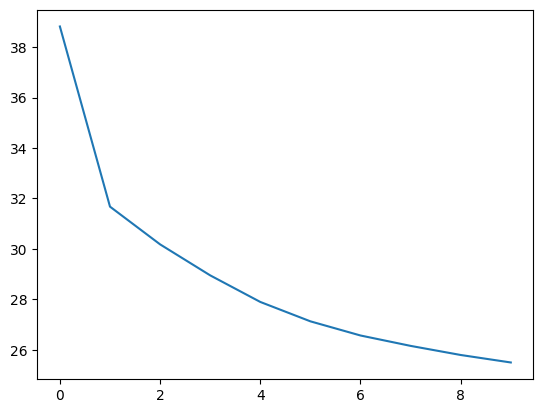

In [101]:
plt.plot(train_loss)

In [102]:
values = None
all_labels = []

with torch.no_grad():
    for (imgs, labels) in train_dl:
        imgs = imgs.to(device)
        imgs = imgs.flatten(1)
        all_labels.extend(list(labels.numpy()))
        latents = enc(imgs)

        if values is None:
            values = latents.cpu()
        else:
            values = torch.vstack([values, latents.cpu()])

In [103]:
cmap = plt.get_cmap('viridis', 10)

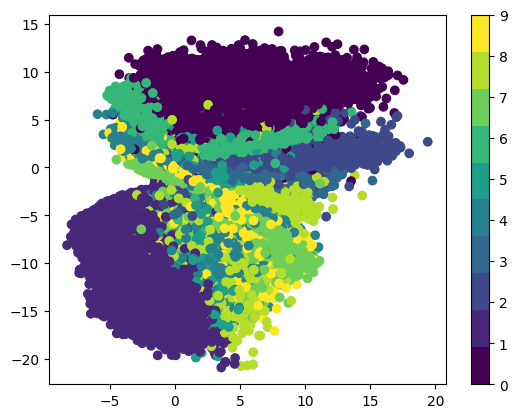

In [104]:
all_labels = np.array(all_labels)
values = values.numpy()
pc = plt.scatter(values[:, 0], values[:, 1], c=all_labels, cmap=cmap)
plt.colorbar(pc)

# **Now we understand the process clearly!**


##Let's go step by step now:

#starting with importing dependancies:

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)


# Hyperparameters


In [106]:
batch_size = 128
learning_rate = 0.001
epochs = 20
latent_dim = 32

# Load CSV data


In [107]:
train_data = pd.read_csv('/content/sample_data/mnist_train_small.csv').values
test_data = pd.read_csv('/content/sample_data/mnist_test.csv').values

# Extract features and labels

In [108]:
train_features, train_labels = train_data[:, 1:], train_data[:, 0]
test_features, test_labels = test_data[:, 1:], test_data[:, 0]

# Convert to PyTorch tensors


In [109]:
train_features = torch.FloatTensor(train_features) / 255.0
test_features = torch.FloatTensor(test_features) / 255.0
train_labels = torch.LongTensor(train_labels)
test_labels = torch.LongTensor(test_labels)


# Create DataLoader

In [110]:
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder architecture

In [111]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, latent_dim), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(latent_dim, input_dim), nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Choose optimizer and criterion


In [112]:
autoencoder_model = Autoencoder(input_dim=784, latent_dim=latent_dim)
autoencoder_optimizer = optim.Adam(autoencoder_model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

# Training function for autoencoder

In [113]:
def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for data in train_loader:
            inputs, _ = data

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader.dataset)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return losses

# Train autoencoder and get losses


In [114]:
losses = train_autoencoder(autoencoder_model, train_loader, criterion, autoencoder_optimizer, epochs)

Epoch [1/20], Loss: 0.0027
Epoch [2/20], Loss: 0.0017
Epoch [3/20], Loss: 0.0014
Epoch [4/20], Loss: 0.0013
Epoch [5/20], Loss: 0.0012
Epoch [6/20], Loss: 0.0011
Epoch [7/20], Loss: 0.0011
Epoch [8/20], Loss: 0.0010
Epoch [9/20], Loss: 0.0010
Epoch [10/20], Loss: 0.0010
Epoch [11/20], Loss: 0.0009
Epoch [12/20], Loss: 0.0009
Epoch [13/20], Loss: 0.0009
Epoch [14/20], Loss: 0.0009
Epoch [15/20], Loss: 0.0009
Epoch [16/20], Loss: 0.0009
Epoch [17/20], Loss: 0.0009
Epoch [18/20], Loss: 0.0009
Epoch [19/20], Loss: 0.0009
Epoch [20/20], Loss: 0.0009


# Plot the losses

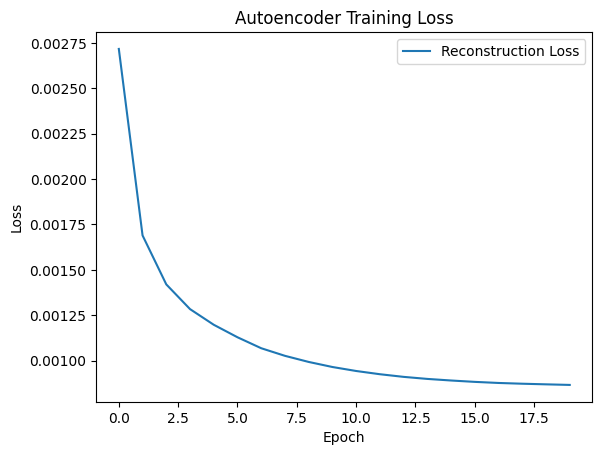

In [115]:
plt.plot(losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.show()

#Now for the VAE:

##**we keep the same hyperparameters and dataloaders:**

### Variational Autoencoder architecture


In [116]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc21 = nn.Linear(256, latent_dim)
        self.fc22 = nn.Linear(256, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### Loss function for VAE

In [117]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

### Choose optimizer and criterion


In [118]:
vae_model = VAE(input_dim=784, latent_dim=latent_dim)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)

### Training function for variational autoencoder


In [119]:
def train_vae(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    losses = []
    kl_divergences = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_kl_divergence = 0.0
        for data in train_loader:
            inputs, _ = data

            optimizer.zero_grad()
            outputs, mu, logvar = model(inputs)
            loss = criterion(outputs, inputs, mu, logvar)

            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_kl_divergence += KLD.item()

        epoch_loss /= len(train_loader.dataset)
        epoch_kl_divergence /= len(train_loader.dataset)
        losses.append(epoch_loss)
        kl_divergences.append(epoch_kl_divergence)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, KL Divergence: {epoch_kl_divergence:.4f}')

    return losses, kl_divergences

### Train VAE and get losses


In [120]:
vae_losses, vae_kl_divergences = train_vae(vae_model, train_loader, vae_loss, vae_optimizer, epochs)


Epoch [1/20], Loss: 224.5932, KL Divergence: 11.1573
Epoch [2/20], Loss: 159.8251, KL Divergence: 16.0034
Epoch [3/20], Loss: 144.2958, KL Divergence: 18.7907
Epoch [4/20], Loss: 135.3966, KL Divergence: 20.6945
Epoch [5/20], Loss: 129.4842, KL Divergence: 22.1102
Epoch [6/20], Loss: 125.1252, KL Divergence: 23.0203
Epoch [7/20], Loss: 121.9636, KL Divergence: 23.6496
Epoch [8/20], Loss: 119.5408, KL Divergence: 24.1771
Epoch [9/20], Loss: 117.6627, KL Divergence: 24.5262
Epoch [10/20], Loss: 116.0902, KL Divergence: 24.7900
Epoch [11/20], Loss: 114.9501, KL Divergence: 25.1245
Epoch [12/20], Loss: 113.8990, KL Divergence: 25.2469
Epoch [13/20], Loss: 113.1484, KL Divergence: 25.3704
Epoch [14/20], Loss: 112.4140, KL Divergence: 25.5067
Epoch [15/20], Loss: 111.7866, KL Divergence: 25.6069
Epoch [16/20], Loss: 111.2306, KL Divergence: 25.6781
Epoch [17/20], Loss: 110.7180, KL Divergence: 25.7718
Epoch [18/20], Loss: 110.3147, KL Divergence: 25.7767
Epoch [19/20], Loss: 110.0191, KL Div

### Plot the reconstruction loss and the KL divergence

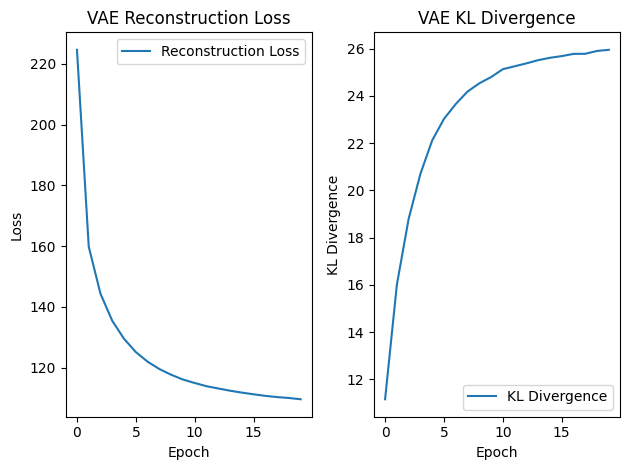

In [121]:
plt.subplot(1, 2, 1)
plt.plot(vae_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Reconstruction Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vae_kl_divergences, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.title('VAE KL Divergence')
plt.legend()

plt.tight_layout()
plt.show()

# Latent space


In [127]:
def get_autoencoder_latent_representation(model, data_loader):
    model.eval()
    latent_space = []
    with torch.no_grad():
        for data in data_loader:
            inputs, _ = data
            latent_space.append(model.encoder(inputs.view(-1, 784)).numpy())
    return np.concatenate(latent_space, axis=0)

## Get latent representation


In [129]:
autoencoder_latent = get_autoencoder_latent_representation(autoencoder_model, test_loader)


## Plot the latent space

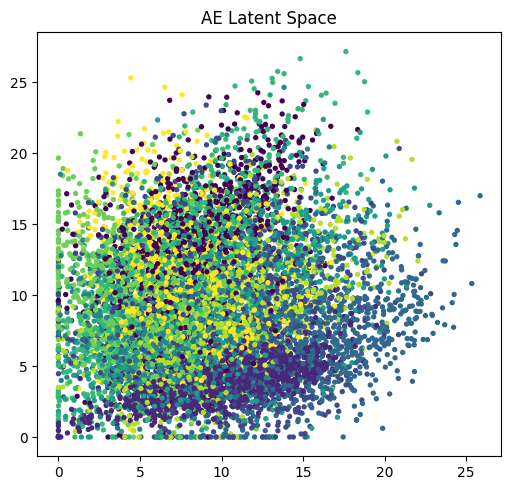

In [128]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(autoencoder_latent[:, 0], autoencoder_latent[:, 1], c=test_labels.numpy(), cmap='viridis', s=8)
plt.title('AE Latent Space')

plt.tight_layout()
plt.show()